# Install Hakai Timeseries Processing Package ( Google Colab)

In [7]:
!pip install git+https://github.com/HakaiInstitute/process_ocean_timeseries.git

  Cloning https://github.com/HakaiInstitute/process_ocean_timeseries.git to c:\users\jessy\appdata\local\temp\pip-req-build-tqfk9956


  Running command git clone -q https://github.com/HakaiInstitute/process_ocean_timeseries.git 'C:\Users\jessy\AppData\Local\Temp\pip-req-build-tqfk9956'


  Created wheel for process-ocean-data: filename=process_ocean_data-0.1.0-py3-none-any.whl size=19554 sha256=8c1097be5cf14e723795fdf96b7d624b980d90da31ad777f47fe0133a16c33ce
  Stored in directory: C:\Users\jessy\AppData\Local\Temp\pip-ephem-wheel-cache-zj0xfhnx\wheels\ad\41\75\50f10ea73423e9b592c7cf28c9a4ad0ce309ceb160fca1763d
Successfully built process-ocean-data


# Import the CTD timeseries method

In [8]:
from process_ocean_data import process_ctd_timeseries
from process_ocean_data.tools import qc as qc

from ipywidgets import widgets, VBox
import xarray as xr
import numpy as np

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Retrieve Hakai Deployment Log

In [9]:
# Retrieve Hakai Instrument Deployment Log 
instrument_log = process_ctd_timeseries.get_hakai_ctd_log()
instrument_log

Retrieve Time Zone Internal Clock Sync or Start Time
Triangulate deployment location


,Project,Instrument Type,Instrument Manufacturer,Instrument Sub Type,Serial Number,Platform,Anchor Type,Scientist,BatteryIn Voltage (V),Deployment Setup,...,Latitude:Triangulation4,Longitude:Triangulation4,Range:Triangulation4,Instrument_clock_seconds_utc_offset,sub_path,file_name,Latitude:Triangulation_Results,Longitude:Triangulation_Results,Latitude,Longitude
0,Hakai Oceanography-Modeling,CTD+DO,Seabird,SBE37 SMP-ODO,21328,Taut Line Mooring,500lb Steel,Jessy Barrette; Jenn Jackson,3.67V,https://drive.google.com/drive/folders/1DkcPgM...,...,None,None,None,0.0,Calvert/DFO3/,Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Cal...,51.601505,-127.531247,51.601505,-127.531247
1,Hakai Oceanography-Modeling,CTD+DO,Seabird,SBE37 SMP-ODO,21421,Taut Line Mooring,500lb Steel,Jessy Barrette; Jenn Jackson,3.67V,https://drive.google.com/drive/folders/1DkcPgM...,...,None,None,None,0.0,Calvert/DFO3/,Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21421_Cal...,51.601505,-127.531247,51.601505,-127.531247
2,Hakai Oceanography-Modeling,CTD+DO,Seabird,SBE37 SMP-ODO,21328,Taut Line Mooring,500lb Steel,Jessy Barrette; Jenn Jackson,3.67V,https://drive.google.com/drive/folders/1f3SSdl...,...,None,None,None,0.0,Calvert/DFO3/,Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Cal...,51.599773,-127.528539,51.599773,-127.528539
3,Hakai Oceanography-Modeling,CTD+DO,Seabird,SBE37 SMP-ODO,21421,Taut Line Mooring,500lb Steel,Jessy Barrette; Jenn Jackson,3.67V,https://drive.google.com/drive/folders/1f3SSdl...,...,None,None,None,0.0,Calvert/DFO3/,Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21421_Cal...,51.599773,-127.528539,51.599773,-127.528539


# Download Data Locally To be Processed

In [10]:
instrument_log = process_ctd_timeseries.download_raw_data(instrument_log)

Download .\Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_20200211-20200828.cnv: : 7.40625MB [00:02,  3.20MB/s]


KeyboardInterrupt: 

In [ ]:
process_ctd_timeseries.get_ctd_qc_config()

{'depth': {'qartod': {'gross_range_test': {'suspect_span': [0, 11000],
    'fail_span': [-5, 11000]},
   'aggregate': {}}},
 'PRESPR01': {'qartod': {'gross_range_test': {'suspect_span': [0, 11000],
    'fail_span': [-5, 11000]},
   'flat_line_test': {'tolerance': 0.001,
    'suspect_threshold': 3600,
    'fail_threshold': 10800},
   'rate_of_change_test': {'threshold': 1},
   'spike_test': {'suspect_threshold': 1, 'fail_threshold': 2},
   'aggregate': {}}},
 'TEMPS901': {'qartod': {'gross_range_test': {'suspect_span': [-2, 60],
    'fail_span': [-3, 100]},
   'flat_line_test': {'tolerance': 0.001,
    'suspect_threshold': 3600,
    'fail_threshold': 10800},
   'rate_of_change_test': {'threshold': 0.01},
   'spike_test': {'suspect_threshold': 0.5, 'fail_threshold': 1},
   'aggregate': {}}},
 'CNDCST01': {'qartod': {'gross_range_test': {'suspect_span': [0, 100],
    'fail_span': [-0.1, 120]},
   'flat_line_test': {'tolerance': 0.001,
    'suspect_threshold': 10800,
    'fail_threshold': 

Read .\Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_20200211-20200828.cnv


Problems with datetime


Save to Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_20200211-20200828_L0.nc
Saving netcdf output file: .\Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_20200211-20200828_L0.nc

Variabes
scan
	long_name: Record Scan Number
	name: scan
	id: 0
	SBE_short_name: scan
	SBE_long_name: Scan Count
	span: ['1', '57721']
time
	long_name: Instrument Time
	units: seconds since 2000, Jan 01 00:00:00
	name: time
	id: 1
	SBE_short_name: timeK
	SBE_long_name: Time, Instrument [seconds]
	span: ['634684801', '652041001']
timeS
	long_name: Elapsed time since instrument start
	units: seconds
	name: timeS
	description: This output seems to have some issues and do not refect time gaps in original data. Use TimeK output as much as possible
	id: 2
	SBE_short_name: timeS
	SBE_long_name: Time, Elapsed [seconds]
	span: ['0.000', '17316000.0']
TEMPS901
	long_name: Sea Water Temperature
	standard_name: sea_water_temperature
	units: degC [ITS-90]
	name: TEMPS901
	id: 3
	SBE_short_name: tv290C
	S

Problems with datetime


Save to Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21421_Calvert-DFO3_20200211-20200828_L0.nc
Saving netcdf output file: .\Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21421_Calvert-DFO3_20200211-20200828_L0.nc

Variabes
scan
	long_name: Record Scan Number
	name: scan
	id: 0
	SBE_short_name: scan
	SBE_long_name: Scan Count
	span: ['1', '57737']
time
	long_name: Instrument Time
	units: seconds since 2000, Jan 01 00:00:00
	name: time
	id: 1
	SBE_short_name: timeK
	SBE_long_name: Time, Instrument [seconds]
	span: ['634686001', '652046101']
timeS
	long_name: Elapsed time since instrument start
	units: seconds
	name: timeS
	description: This output seems to have some issues and do not refect time gaps in original data. Use TimeK output as much as possible
	id: 2
	SBE_short_name: timeS
	SBE_long_name: Time, Elapsed [seconds]
	span: ['0.000', '17320800.0']
TEMPS901
	long_name: Sea Water Temperature
	standard_name: sea_water_temperature
	units: degC [ITS-90]
	name: TEMPS901
	id: 3
	SBE_short_name: tv290C
	S

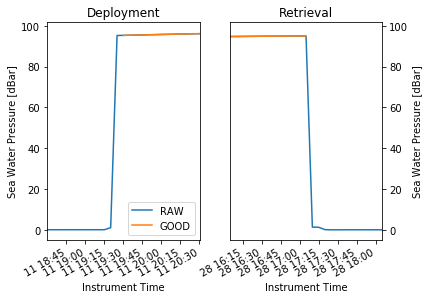

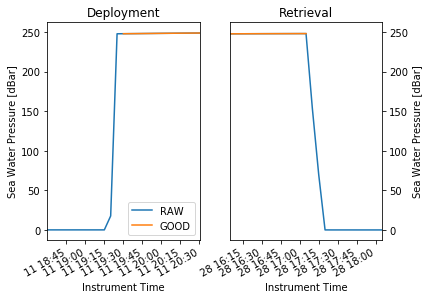

In [ ]:
# Apply Standard Processing to the data
file_list = []
for index, row in instrument_log.iterrows():
    file_list +=[process_ctd_timeseries.process_data(row)]

In [ ]:
# Retrieve processed Files
file_list = [item for item in file_list if item]
l1_files = [item['l1'] for item in file_list]

# Manual Review (Not compatible with Google Colab)


In [ ]:
# Review one file at the time
file_selection = widgets.Select(
    options=l1_files,
    value=l1_files[0],
    description='File to review:'
)
file_selection

Select(description='File to review:', options=('.\\Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_202…

In [ ]:
ds = xr.open_dataset('Hakai_Seabird-CTD+DO-SBE37 SMP-ODO-SN21328_Calvert-DFO3_20200211-20200828_L1.nc')

In [ ]:
# Load Selected Dataset
ds = xr.open_dataset(file_selection.value)


In [ ]:
# Copy qartod_aggregate as review
review_flag = '_qartod_aggregate'
for var in ds:
    if var.endswith(review_flag):
        ds[var.replace(review_flag,'_review_flag')] = ds[var]

df = ds.to_dataframe()
index_names = df.index.names
df = df.reset_index()

In [12]:
# NOT COMPATIBLE WITH GOOGLE COLAB 
review_flag_suffix = "_review_flag"
qc.manual_qc_interface(df,
                       variable_list= ['TEMPS901','PSALST01', 'DOXYZZ01', 'CNDCST01'],
                       flags= 'QARTOD',
                       review_flag=review_flag_suffix
                       )

In [14]:
# Update Dataset with QCed results
ds2 = ds.copy()

for var in df.filter(like=review_flag_suffix).columns:
    temp = ds[var]
    ds2[var] = (temp.dims,df[var])
    ds2[var].attrs = temp.attrs

# Save to NetCDF
ds2.to_netcdf()

# Generate QCed files
1. Level 1: add manual flag to a review column
1. Level 2: Drop Bad Data 


In [42]:
# Seabird tends to have a fill value equal -9E-29. We'll replace that by np.nan
old_ds = ds.copy()
for name, value in ds.items():
    if '_FillValue' in value.encoding and 'missing_value' in value.encoding:
        value.encoding.pop('_FillValue')
for name, len in ds.dims.items():
    if '_FillValue' in ds[name].encoding and 'missing_value' in ds[name].encoding:
        ds[name].encoding.pop('_FillValue')

In [55]:
# Level 1 Files
# Add selected flags back in the L1 file.
for var in df.filter(like=review_flag_suffix+'_final').columns:
    associated_variable = var.replace(review_flag_suffix+'_final','')
    ds[var] = (ds[associated_variable].dims, df[var])
    
    if 'ancillary_variable' in ds[associated_variable].attrs:
        ds[associated_variable].attrs["ancillary_variable"] += ' '+var
    else:
        ds[associated_variable].attrs["ancillary_variable"] = var
        
# Save to NetCDF
l1_review_file = file_selection.value.rsplit('.', 1)[0]+'_review.nc'
ds2.to_netcdf(l1_review_file)

In [59]:
# Generate Level 2 Flag
l1_review_file = file_selection.value.rsplit('.',1)[0]+'_review.nc'
ds_level2 = xr.open_dataset(l1_review_file)

# consider_only=[1]
# fillValue = np.nan
# for name, value in ds_level2.items():
#     if review_flag_suffix in name:
#         related_variable = name.replace(review_flag_suffix+'_final','')
        
#         ds_level2[related_variable] = ds_level2[related_variable].where(ds_level2[name].isin(consider_only))
        

In [75]:
ds['PSALST01_review_flag_final']

<xarray.DataArray 'PSALST01_review_flag_final' (time: 57284)>
array([1, 1, 1, ..., 1, 1, 1], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-11T19:30:04 ... 2020-08-28T17:05:04